First we need to upload the dataset, for that I have uploaded the data onto GitHub and then used the link to link the data to pandas using the url.

In [1]:
import pandas as pd
import platform
import sklearn
import numpy as np
import graphviz
import matplotlib
import matplotlib.pyplot as plt 
url='https://raw.githubusercontent.com/AKing1998/Churn_Prediction_Model/master/Churn_Modelling.csv'
data=pd.read_csv(url)
data.shape

(10000, 14)

In [2]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Text Preprocessing**

We need to remove any data with missing values

In [3]:
data = data.dropna(how="all")  # remove samples with all missing values
data.shape

(10000, 14)

We need to remove data with missing information

In [4]:
data = data[~data.duplicated()] # remove duplicates
data.shape

(10000, 14)

In [5]:
data.describe(include='all')  

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


We are now specifying which all columns are catagorical as in they only have a a finite number of options like gender or country and which are numerical like age or credit score.

In [0]:
categorical_features = [
    "Gender",
    "Geography",
    "NumOfProducts",
    "HasCrCard",
    "IsActiveMember",
]
numerical_features = ["CreditScore", "Age", "Tenure","Balance","EstimatedSalary",]
target = "Exited"


**Data Visulaization**

To analyze categorical features, we use bar charts. We observe that people in Germany and Spain as well as people without credit cards are less represented in the data.

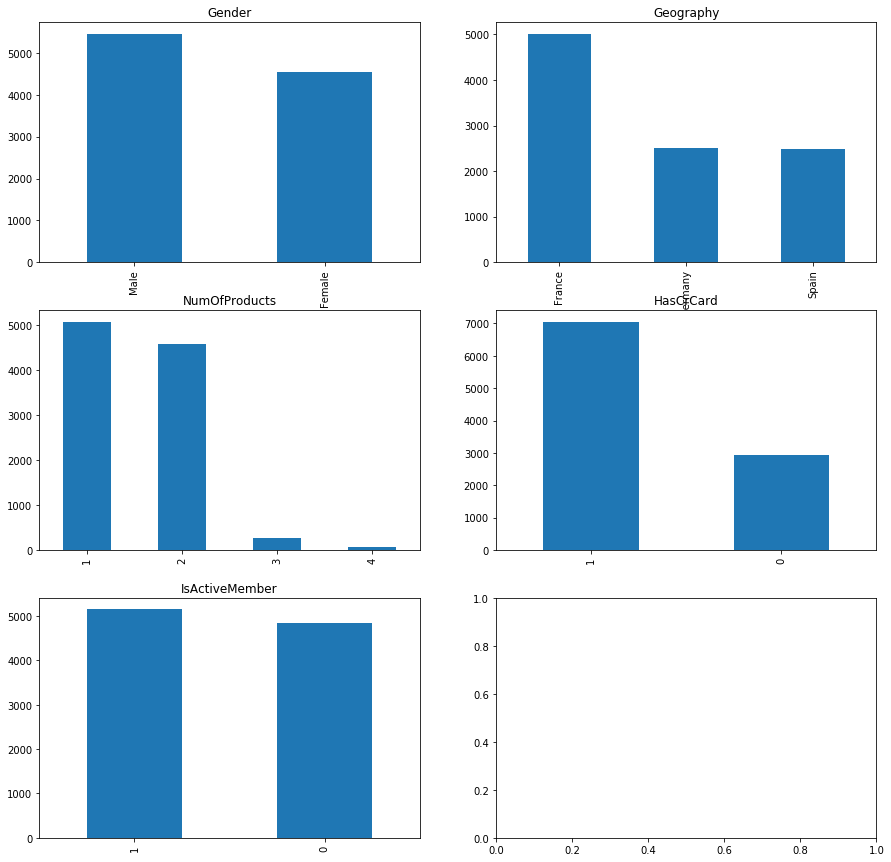

In [7]:
ROWS, COLS = 3,2
fig, ax = plt.subplots(ROWS, COLS, figsize=(15,15))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    data[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)
 

The distribution of the number of people that exited or not shows that there are much more people who did'nt exit when compared to those who did. The model would achieve that more accuracy for the larger class i.e, those who didnt exit hence we might need to consider looking at the recall or precision as performance metrics. 

Text(0.5, 1.0, 'Exited')

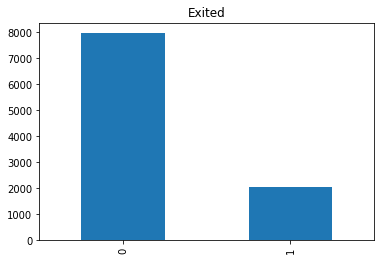

In [8]:
data[target].value_counts().plot('bar').set_title('Exited')


We need to conver the catagorical data from labels that are not easily understoon like in the case of Geography( Germany, France , Spain) to 0,1,2. This wil help the algorithm to work with the data. 

In [9]:
from sklearn.preprocessing import LabelEncoder

categorical_feature_names = []
label_encoders = {}
for categorical in categorical_features + [target]:
    label_encoders[categorical] = LabelEncoder()
    data[categorical] = label_encoders[categorical].fit_transform(data[categorical])
    names = label_encoders[categorical].classes_.tolist()
    print('Label encoder %s - values: %s' % (categorical, names))
    if categorical == target:
        continue
    categorical_feature_names.extend([categorical + '_' + str(name) for name in names])

Label encoder Gender - values: ['Female', 'Male']
Label encoder Geography - values: ['France', 'Germany', 'Spain']
Label encoder NumOfProducts - values: [1, 2, 3, 4]
Label encoder HasCrCard - values: [0, 1]
Label encoder IsActiveMember - values: [0, 1]
Label encoder Exited - values: [0, 1]


Decision Tree
We are choosing a decision tree because of its simplicity and since we can easily interpret what is going on. 

We use sklearn to create our classifier. We create pipelines that define feature processing and the classification. 

We feed the input to the pipeline where the features are preprocessed and then trains the classifier. After trained it feeds more inputs to calculate the output. 



In [0]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, df):
        return df[self.key]

In our pipeline we process the categorical and numerical features separatly. Sine they are fundementally different and since one shouldn’t be passing continuous variables into a OneHotEncoder or vice versa for Scalers, we  onehot encode categorical features and scale the numerical features by removing the mean and sacling them to unit variance. 

In [0]:
pipeline = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                transformer_list=[
                    (
                        "categorical_features",
                        Pipeline(
                            [
                                ("selector", ItemSelector(key=categorical_features)),
                                ("onehot", OneHotEncoder()),
                            ]
                        ),
                    )
                ]
                + [
                    (
                        "numerical_features",
                        Pipeline(
                            [
                                ("selector", ItemSelector(key=numerical_features)),
                                ("scalar", StandardScaler()),
                            ]
                        ),
                    )
                ]
            ),
        ),
        ("classifier", tree.DecisionTreeClassifier(max_depth=3, random_state=42)),
    ]
)

We then split the data , 75% to train and 25% to test. 

Then we fit the pipline and make our predicitions. 

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

pipeline.fit(data_train, data_train[target])
pred = pipeline.predict(data_test)

With classification_report we calculate that precison and recall with the actual and predicted values. 

For people who exited ( class 1 ) the model gets 0.86 precision and 0.98 recall, as for people who didnt exit ( class 0 ) the model gets 0.78 precision and 0.34 recall. 

In conclusion our model is not very accurate at prediciting people who did leave.

In [13]:
from sklearn.metrics import classification_report

print(classification_report(data_test[target], pred))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      2003
           1       0.78      0.34      0.47       497

    accuracy                           0.85      2500
   macro avg       0.82      0.66      0.69      2500
weighted avg       0.84      0.85      0.83      2500



We can interpret the model using graphviz which shows us which features our model used and check if some unwanted featutre got into our algorithm or not. We see that for each Customer. 

For example if the prediction of Age is less that 0.535 then it follows the True tree branch and if not the False tree branch. 

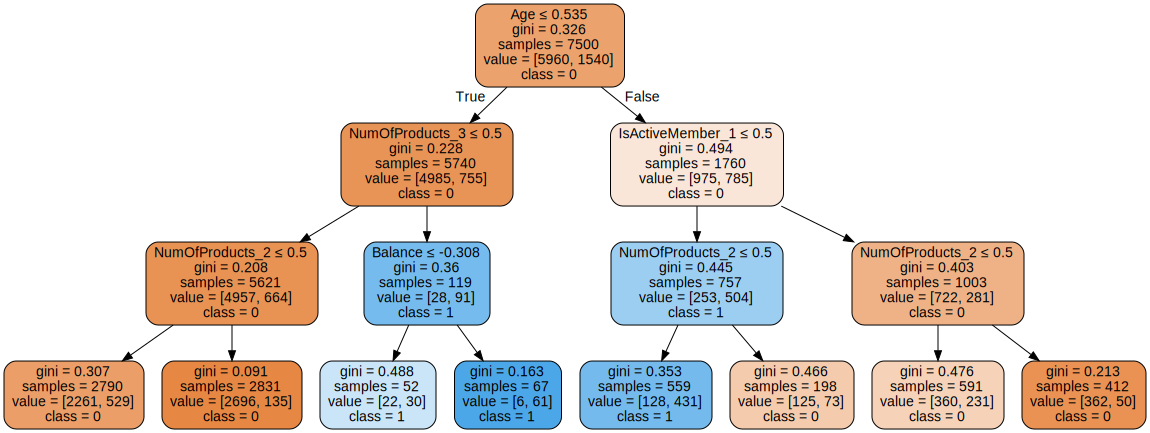

In [14]:
dot_data = tree.export_graphviz(pipeline.named_steps['classifier'], out_file=None, 
                         feature_names = categorical_feature_names + numerical_features,
                         class_names=[str(el) for el in pipeline.named_steps.classifier.classes_],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
graph